                 emp_title  emp_length state homeownership  annual_income  \
0  global config engineer          3.0    NJ      MORTGAGE        90000.0   
1   warehouse office clerk        10.0    HI          RENT        40000.0   
2                 assembly         3.0    WI          RENT        40000.0   
3         customer service         1.0    PA          RENT        30000.0   
4     security supervisor         10.0    CA          RENT        35000.0   

   verified_income  debt_to_income  annual_income_joint  \
0         Verified           18.01                  NaN   
1     Not Verified            5.04                  NaN   
2  Source Verified           21.15                  NaN   
3     Not Verified           10.16                  NaN   
4         Verified           57.96              57000.0   

  verification_income_joint  debt_to_income_joint  ...  sub_grade  \
0                       NaN                   NaN  ...         C3   
1                       NaN                 

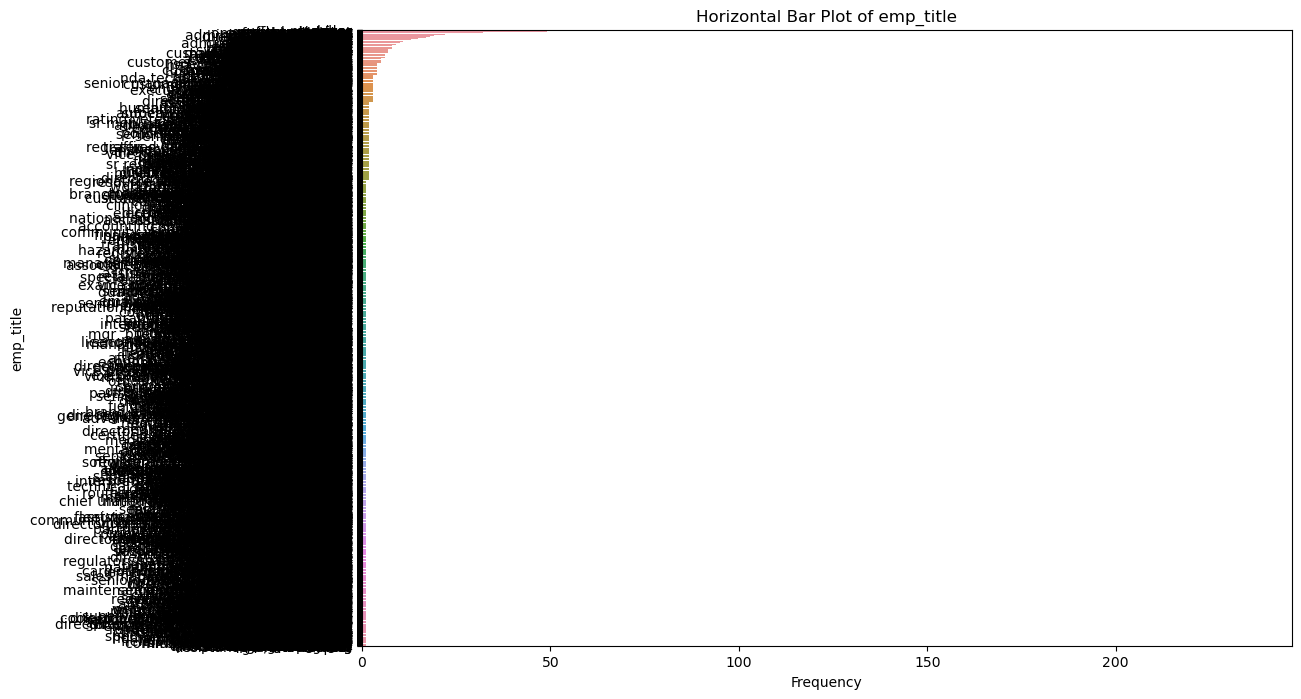

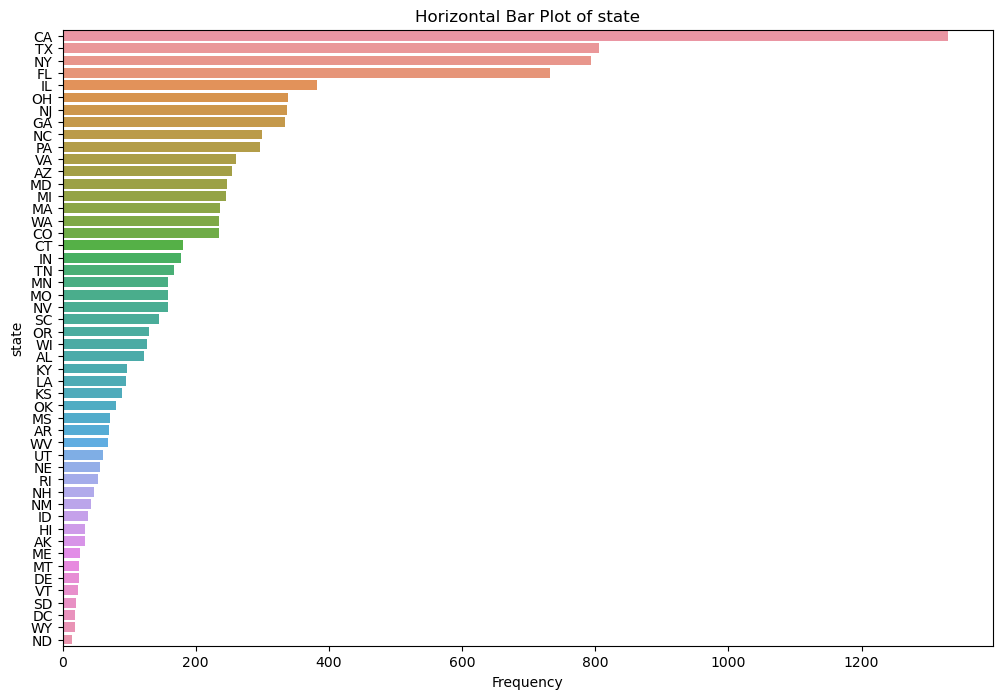

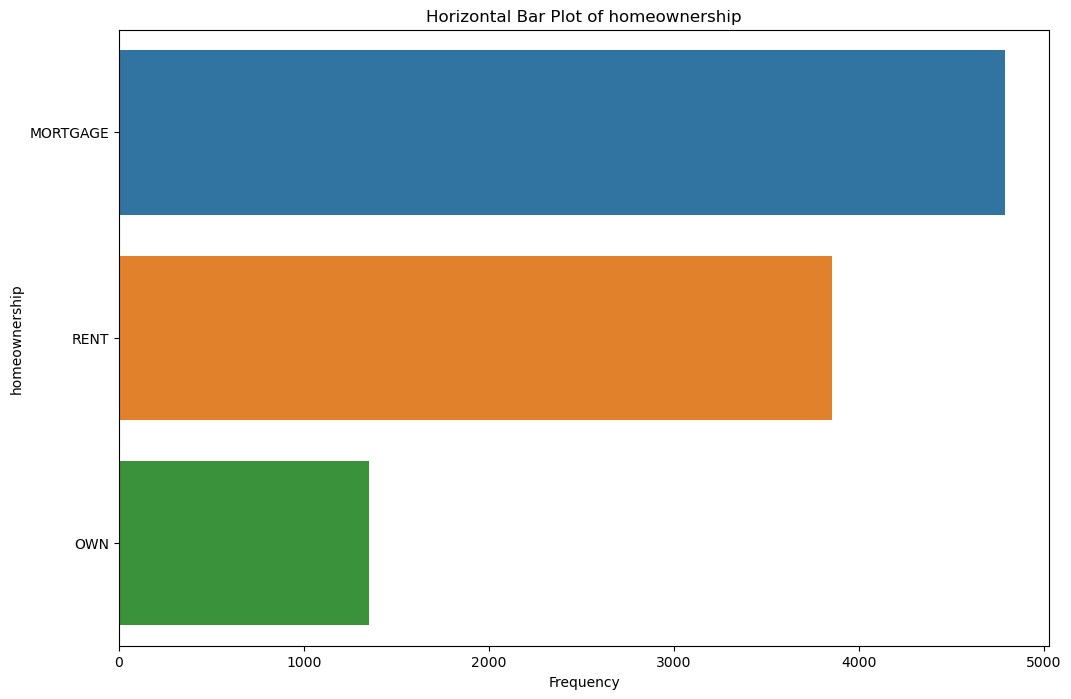

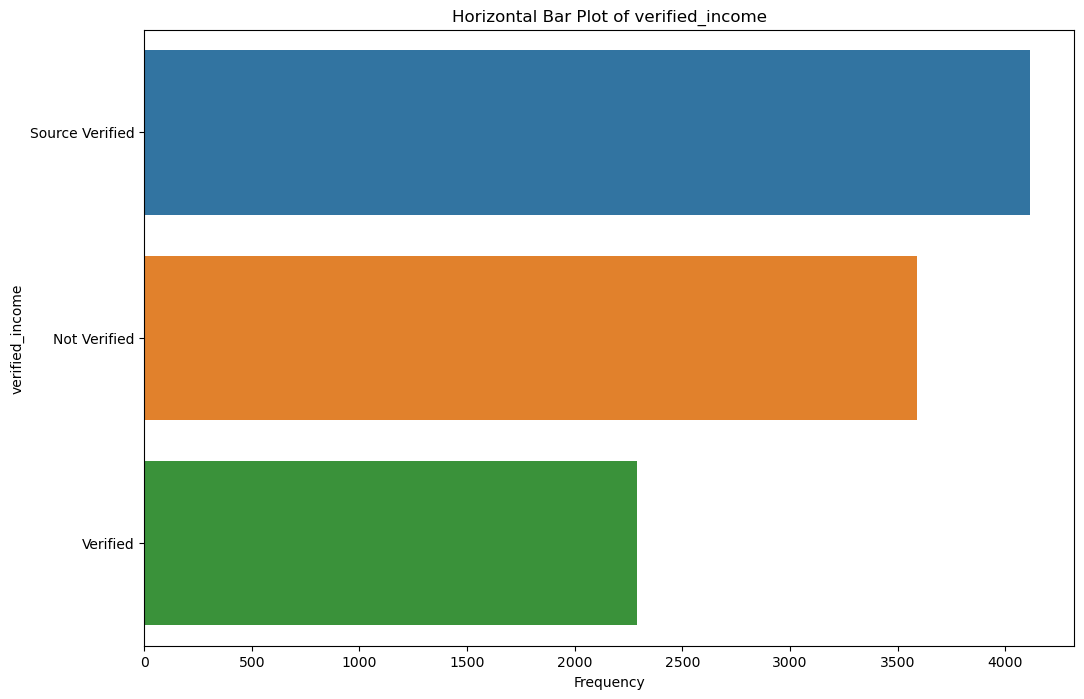

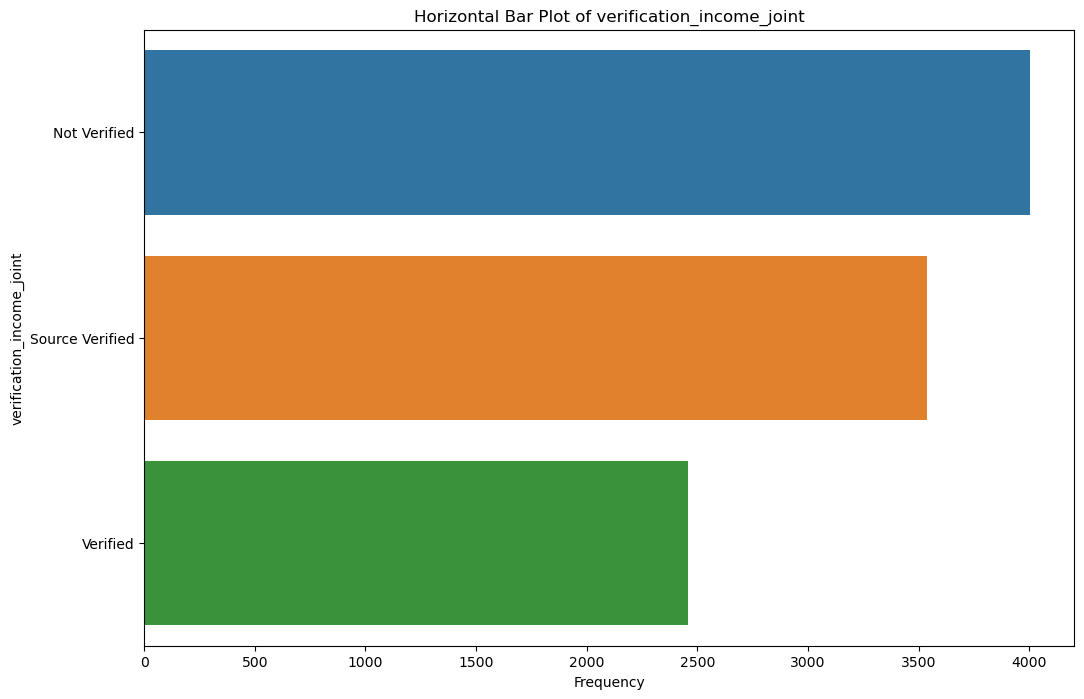

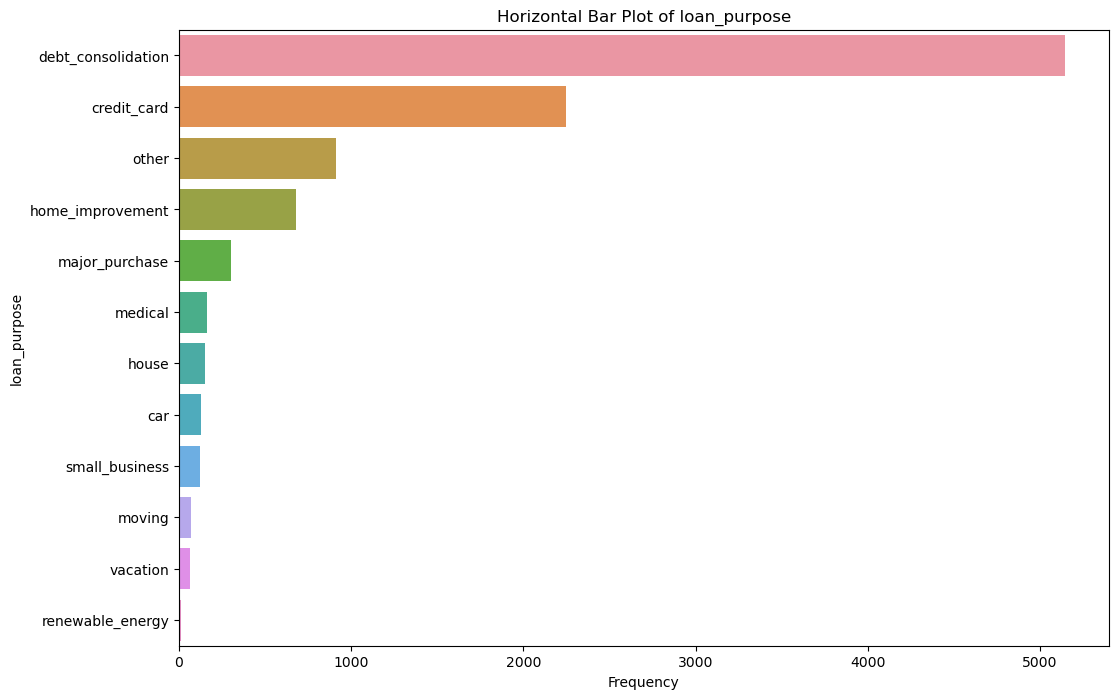

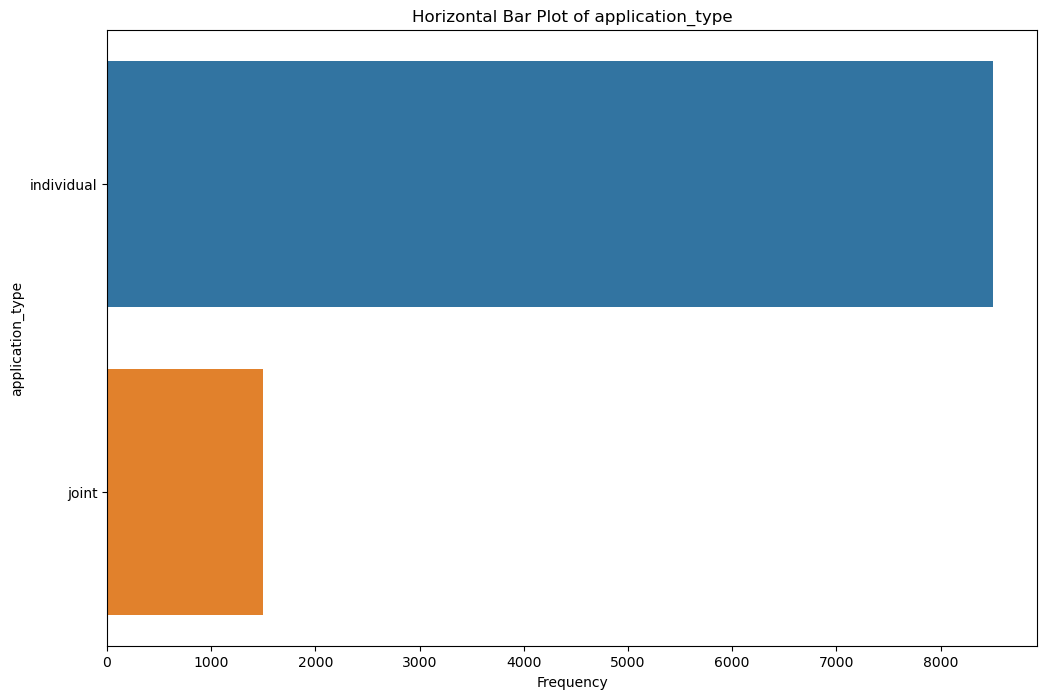

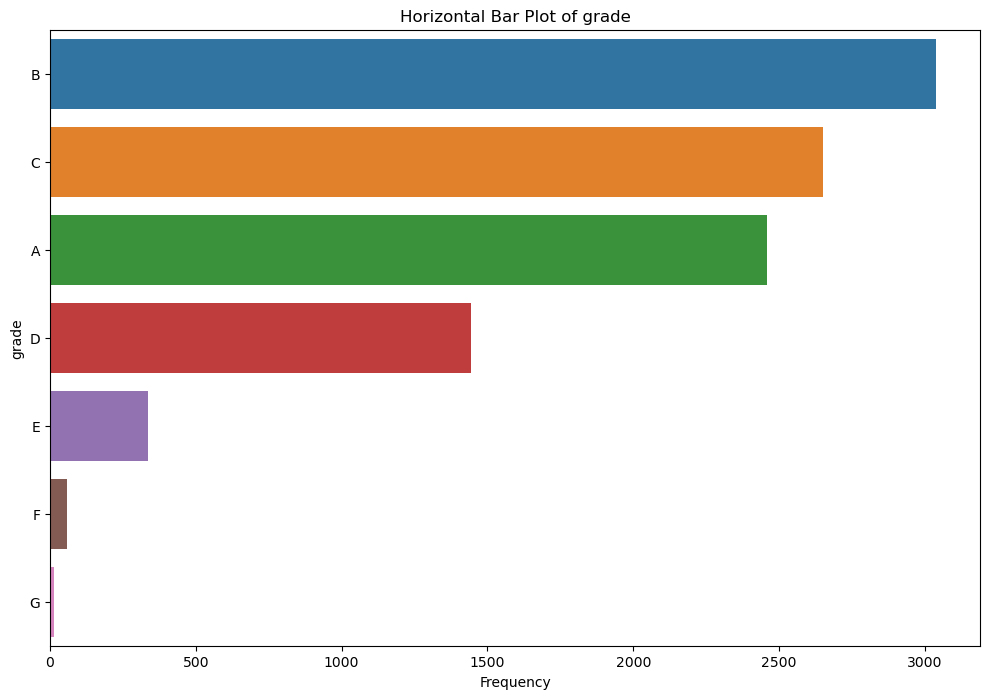

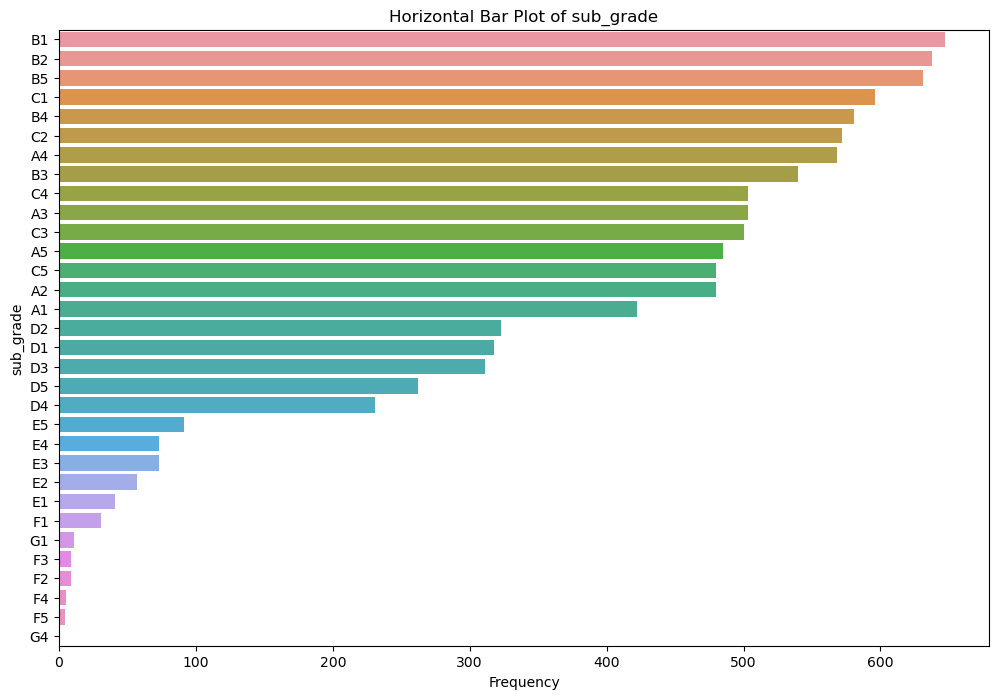

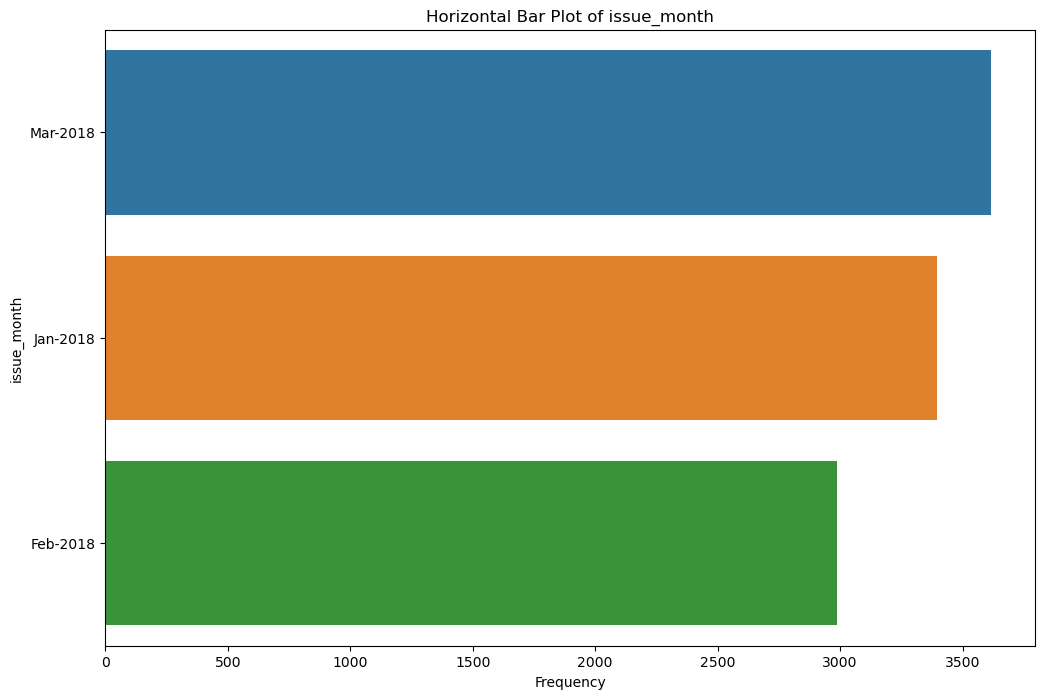

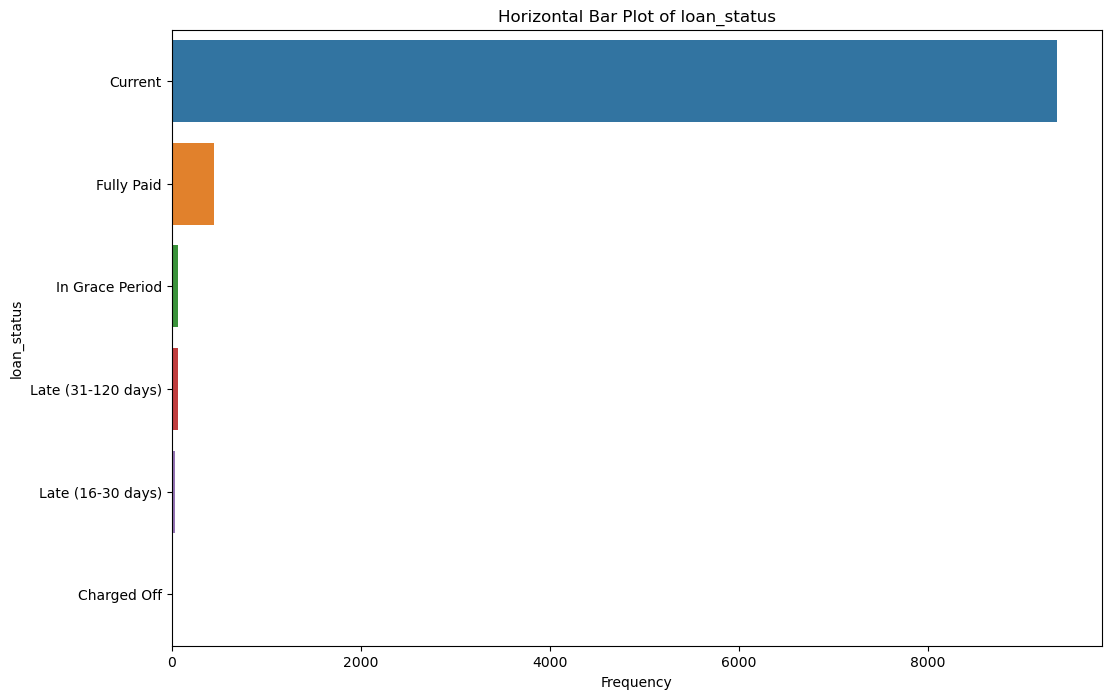

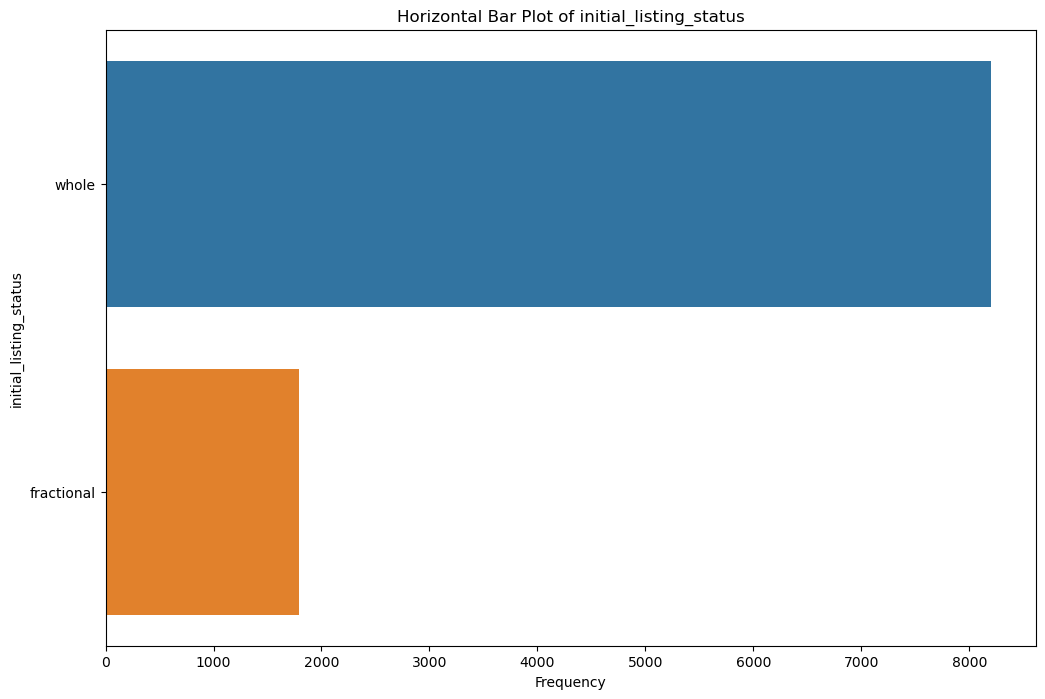

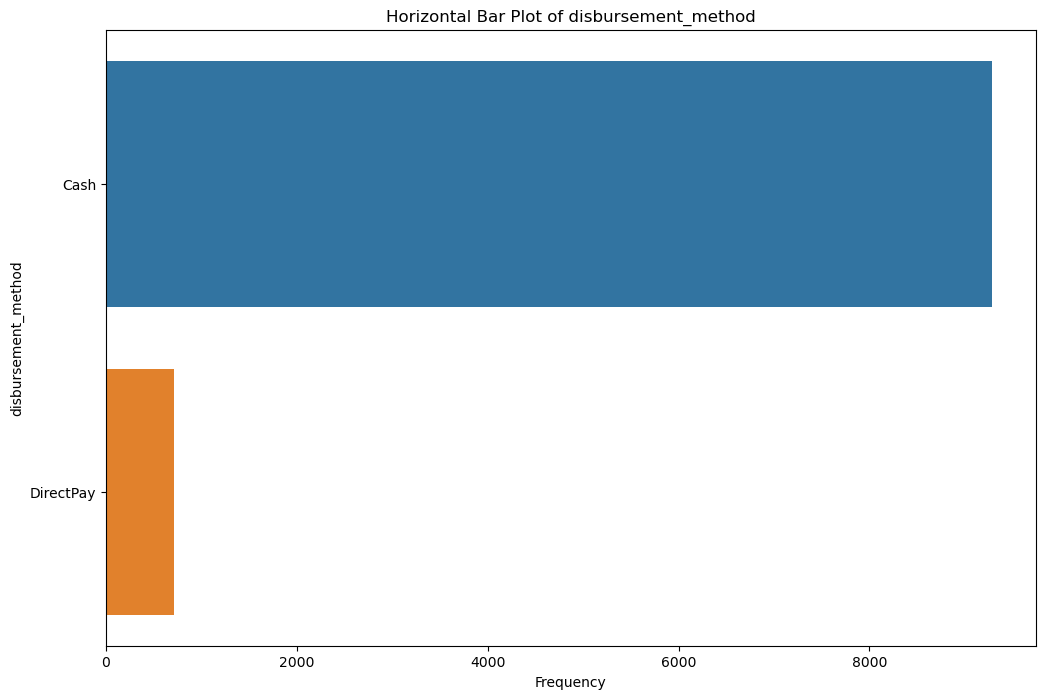

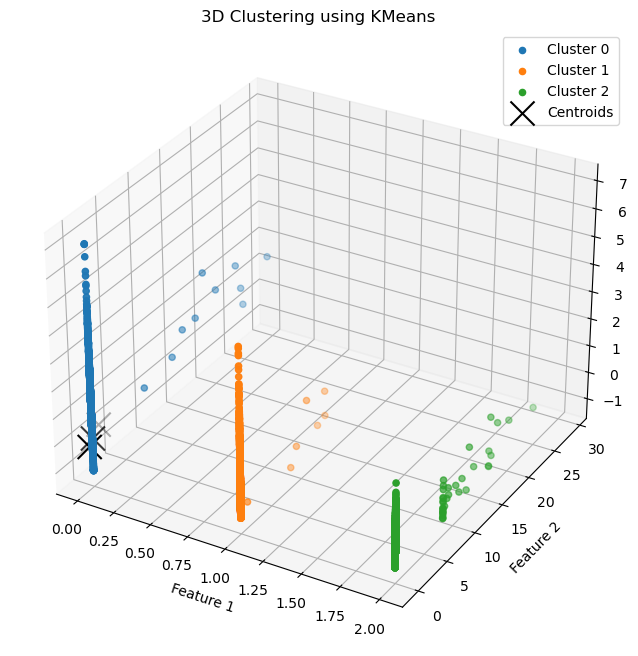

Best parameters for RandomForest Classifier: {'max_depth': None, 'n_estimators': 100}
Best cross-validation accuracy: 0.9821428571428571
RandomForest Classifier Metrics:
Balanced Accuracy: 0.5
Accuracy: 0.9823333333333333
Classification Report:
{'Class 0': {'precision': 0.9823333333333333, 'recall': 1.0, 'f1-score': 0.9910879435009248, 'support': 2947.0}, 'Class 1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 53.0}, 'accuracy': 0.9823333333333333, 'macro avg': {'precision': 0.49116666666666664, 'recall': 0.5, 'f1-score': 0.4955439717504624, 'support': 3000.0}, 'weighted avg': {'precision': 0.9649787777777777, 'recall': 0.9823333333333333, 'f1-score': 0.9735787231657417, 'support': 3000.0}}
Best parameters for AdaBoost Classifier: {'learning_rate': 1.0, 'n_estimators': 50}
Best cross-validation accuracy: 0.9855714285714285
AdaBoost Classifier Metrics:
Balanced Accuracy: 0.6317361435678112
Accuracy: 0.9863333333333333
Classification Report:
{'Class 0': {'precision': 0.9

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("/Users/vishnuvardhan/Documents/Fintech/Project/Project2/loans_full_schema.csv")

# Inspect the Data
print(df.head())  # Display the first few rows of the DataFrame
print(df.info())  # Display information about the DataFrame, including data types

# Data Cleaning
# Handle missing values
df.fillna(method='ffill', inplace=True)  # Forward fill missing values
df.dropna(inplace=True)  # Drop any remaining rows with missing values
# Convert object columns to string type
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)

# Data Analysis
# Summary statistics for numeric columns
print(df.describe())

# Data Visualization using Horizontal Bar Plots
# Visualize the frequency of each category for object columns
for col in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(12, 8))
    sns.countplot(data=df, y=col, order=df[col].value_counts().index)
    plt.title(f'Horizontal Bar Plot of {col}')
    plt.xlabel('Frequency')
    plt.ylabel(col)
    plt.show()

# Data Transformation
# Perform any necessary data transformations
# For example, you can encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, drop_first=True)
# Save the cleaned and transformed data


df = pd.read_csv("/Users/vishnuvardhan/Documents/Fintech/Project/Project2/loans_full_schema.csv")
# Data Preprocessing
# Handle missing values and encode categorical variables
# Handle missing values
df[['verification_income_joint', 'annual_income_joint', 'debt_to_income_joint']] = df[
    ['verification_income_joint', 'annual_income_joint', 'debt_to_income_joint']].fillna('NA')
df['months_since_90d_late'] = df['months_since_90d_late'].fillna('not_late').astype(str)
df['months_since_last_delinq'] = df['months_since_last_delinq'].fillna('not_late_delinq').astype(str)
df['months_since_last_credit_inquiry'] = df['months_since_last_credit_inquiry'].fillna('not_credit_inquiry').astype(str)
df['emp_title'] = df['emp_title'].fillna('No Title').astype(str)
df['emp_length'] = df['emp_length'].fillna('No Length').astype(str)
df['debt_to_income'] = df['debt_to_income'].fillna('joint').astype(str)
df.drop('num_accounts_120d_past_due', inplace=True, axis=1)

# Risk category
def categorize_risk(status):
    if status in ['Fully Paid', 'Current']:
        return 0
    elif status in ['In grace period', 'Late(31-120days)', 'Late(16-30days)']:
        return 1
    else:
        return 1

df['Risk_Category'] = df['loan_status'].apply(categorize_risk)
df.drop('loan_status', inplace=True, axis=1)
categorical_variables = list(df.dtypes[df.dtypes == "object"].index)
numeric_variables = list(df.dtypes[df.dtypes != "object"].index)

df[categorical_variables] = df[categorical_variables].astype(str)

# One-hot encoding
enc = OneHotEncoder(sparse=False)
encoded_data = enc.fit_transform(df[categorical_variables])
feature_names = enc.get_feature_names_out(categorical_variables)
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)
numerical_df = df[numeric_variables]

# Standard scaling
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(numerical_df)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_df.columns)
df_scaled = pd.concat([encoded_df, scaled_numerical_df], axis=1)
df_scaled['Risk_Category'] = df['Risk_Category']

# Apply Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_clustered = df_scaled.copy()
df_clustered['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualize 3D Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in np.unique(df_clustered['Cluster']):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster]
    ax.scatter(cluster_data.iloc[:, -1], cluster_data.iloc[:, -3], cluster_data.iloc[:, -4], label=f'Cluster {cluster}')

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, -3], kmeans.cluster_centers_[:, -4],
           marker='x', s=300, c='black', label='Centroids')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('3D Clustering using KMeans')
ax.legend()

plt.show()

# Model Training and Evaluation
X = df_scaled.drop(columns='Risk_Category')
y = df_scaled['Risk_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Initialize models
randf_classifier = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
adb_classifier = AdaBoostClassifier(random_state=42)
log_reg = LogisticRegression(class_weight=class_weight_dict)
svm_clf = SVC(class_weight=class_weight_dict, random_state=42)

models = {
    'RandomForest Classifier': randf_classifier,
    'AdaBoost Classifier': adb_classifier,
    'Logistic Regression': log_reg,
    'SVM Classifier': svm_clf
}

best_models = {}

for name, model in models.items():
    params = {}
    if name == 'RandomForest Classifier':
        params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 5, 10]}
    elif name == 'AdaBoost Classifier':
        params = {'n_estimators': [50, 100, 150], 'learning_rate': [0.1, 0.5, 1.0]}
    elif name == 'Logistic Regression':
        params = {'C': [0.1, 1, 10]}
    elif name == 'SVM Classifier':
        params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    
    grid_search = GridSearchCV(model, param_grid=params, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_}")
    print("="*50)
    
    # Evaluate best model
    y_pred = best_models[name].predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)
    
    print(f"{name} Metrics:")
    print(f"Balanced Accuracy: {balanced_accuracy}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)


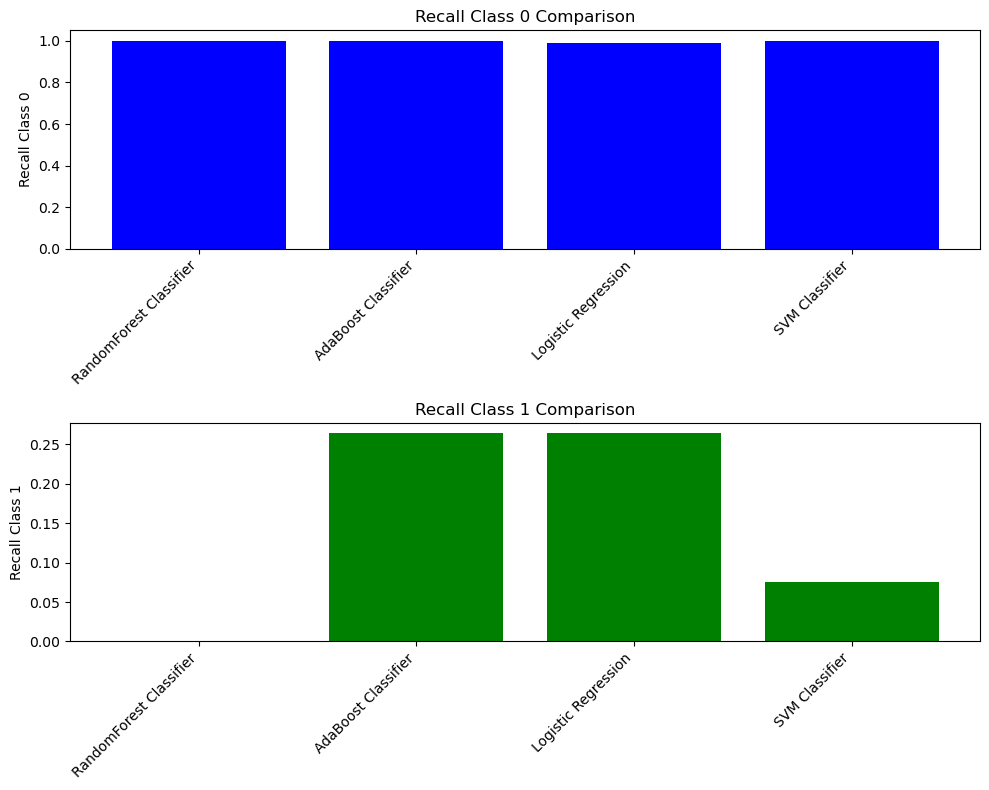

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define model names
model_names = ['RandomForest Classifier', 'AdaBoost Classifier', 'Logistic Regression', 'SVM Classifier']

# Define metrics
metrics = ['Recall Class 0', 'Recall Class 1']

# Define values for each metric
recall_class_0_values = [1.0, 0.999321343739396, 0.989480827960638, 0.999660671869698]
recall_class_1_values = [0.0, 0.2641509433962264, 0.2641509433962264, 0.07547169811320754]

# Create bar plots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot recall for class 0
axs[0].bar(model_names, recall_class_0_values, color='blue')
axs[0].set_title('Recall Class 0 Comparison')
axs[0].set_ylabel('Recall Class 0')

# Plot recall for class 1
axs[1].bar(model_names, recall_class_1_values, color='green')
axs[1].set_title('Recall Class 1 Comparison')
axs[1].set_ylabel('Recall Class 1')

# Rotate x-axis labels
for ax in axs:
    ax.set_xticklabels(model_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()
